## Code to Compute Asymptotic Contributions of Smooth Contributing Points
The code below computes asymptotic expansions of strictly or finitely minimal smooth contributing points, using Theorem 5.2 and Corollary 5.2 from the textbook.  *Note:* The [multivariate_generating_functions (mgf) package](https://doc.sagemath.org/html/en/reference/asymptotic/sage/rings/asymptotic/asymptotics_multivariate_generating_functions.html) has the capability to perform similar computations, however for completeness (and because the mgf package currently needs work to fix various errors) we implement Theorem 5.2 directly using the DifferentialWeylAlgebra package. 

*Requirements: None*

In [1]:
# Set a parameter to help simplify some algebraic numbers
maxima_calculus('algebraic: true;')

# Procedure to get Hessian appearing in asymptotics
# Input: H, member of the symbolic ring
#        r, direction vector (which can contain symbolic entries)
#        vars, vector of variables
#        CP, a dictionary mapping elements of vars
# Output: The Hessian H defined in Lemma 5.5 of the textbook at the point w defined by CP
def getHes(H,r,vars,CP):
    dd = len(vars)
    V = zero_vector(SR,dd)
    U = matrix(SR,dd)
    M = matrix(SR,dd-1)

    for j in range(dd):
        V[j] = r[j]/r[-1]
        for i in range(dd):
            U[i,j] = vars[i]*vars[j]*diff(H,vars[i],vars[j])/vars[-1]/diff(H,vars[-1])
    for i in range(dd-1):
        for j in range(dd-1):
            M[i,j] = V[i]*V[j] + U[i,j] - V[j]*U[i,-1] - V[i]*U[j,-1] + V[i]*V[j]*U[-1,-1]
            if i == j: M[i,j] = M[i,j] + V[i]
    return M(CP)

# Procedure to apply differential operator to f and set all variables to zero
# Input: dop, element of a DifferentialWeylAlgebra over a polynomial ring
#        f, an element of the base polynomial ring of dop
# Output: dop(f) evaluated when all variables are zero
def eval_op(dop, f):
    if len(f.parent().gens()) == 1:
        return add([prod([factorial(k) for k in E[0][1]])*E[1]*f[E[0][1][0]] for E in dop])
    else:
        return add([prod([factorial(k) for k in E[0][1]])*E[1]*f[(v for v in E[0][1])] for E in dop])

# Procedure to get critical points of rational function with denominator H, in direction r
# Input: H, member of the symbolic ring
#        r, direction vector (which can contain symbolic entries)
#        vars, vector of variables
# Output: Solutions (if found by solve) of the smooth critical point equations of H in the direction r
def critpt(H,r,vars):
    d = len(vars)
    criteqs = [H] + [r[j]*vars[0]*diff(H,vars[0]) - r[0]*vars[j]*diff(H,vars[j]) for j in range(1,d)]
    return solve(criteqs,vars,solution_dict=true)

# Procedure to compute asymptotic contribution of a strictly minimal contributing point
# Input: G, member of the symbolic ring
#        H, member of the symbolic ring
#        r, direction vector (which can contain symbolic entries)
#        vars, vector of variables
#        CP, a dictionary mapping elements of vars to coordinates of a strictly minimal contributing point
#        M, positive integer describing the number of terms in the asymptotic expansion to compute
#        g, parametrization of variable vars[-1] near CP, in terms of the remaining variables
# Output: ex, pw, se such that ex*pw*(se+O(n^(M-1)) gives an asymptotic expansion of the r-diagonal of 
#         G/H in the variables vars, to order M.
# NOTE: Unlike the textbook, M here refers to the number of terms in the expansion
#       (not the order of the expansion, so M should be at least 1)
def smoothContrib(G,H,r,vars,CP,M,g):
    # Preliminary definitions
    dd = len(vars)
    field = SR
    tvars = list(var('t%d'%i) for i in range(dd-1))
    dvars = list(var('dt%d'%i) for i in range(dd-1))

    # Define differential Weyl algebra and set variable names
    W = DifferentialWeylAlgebra(PolynomialRing(field,tvars))
    WR = W.base_ring()
    T = PolynomialRing(field,tvars).gens()
    D = list(W.differentials())

    # Compute Hessian matrix and differential operator Epsilon
    HES = getHes(H,r,vars,CP)
    HESinv = HES.inverse()
    v = matrix(W,[D[k] for k in range(dd-1)])
    Epsilon = -(v * HESinv.change_ring(W) * v.transpose())[0,0]

    # Define quantities for calculating asymptotics
    tsubs = [v == v.subs(CP)*exp(I*t) for [v,t] in zip(vars,tvars)]
    tsubs += [vars[-1]==g.subs(tsubs)]
    P = (-G/g/diff(H,vars[-1])).subs(tsubs)
    psi = log(g.subs(tsubs)/g.subs(CP)) + I * add([r[k]*tvars[k] for k in range(dd-1)])/r[-1]
    v = matrix(SR,[tvars[k] for k in range(dd-1)])
    psiTilde = psi - (v * HES * v.transpose())[0,0]/2

    # Recursive function to convert symbolic expression to polynomial in t variables
    def to_poly(p,k):
        if k == 0:
            return add([a*T[k]^int(b) for [a,b] in p.coefficients(tvars[k])])
        return add([to_poly(a,k-1)*T[k]^int(b) for [a,b] in p.coefficients(tvars[k])])

    # Compute Taylor expansions to sufficient orders
    N = 2*M
    PsiSeries = to_poly(taylor(psiTilde,*((v,0) for v in tvars), N),dd-2)
    PSeries = to_poly(taylor(P,*((v,0) for v in tvars), N),dd-2)

    # Precompute products used for asymptotics
    EE = [Epsilon^k for k in range(3*M-2)]
    PP = [PSeries] + [0 for k in range(2*M-2)]
    for k in range(1,2*M-1):
        PP[k] = PP[k-1]*PsiSeries
    
    # Function to compute constants appearing in asymptotic expansion
    def Clj(l,j):
        return (-1)^j*SR(eval_op(EE[l+j],PP[l]))/(2^(l+j)*factorial(l)*factorial(l+j))
    
    # Compute different parts of asymptotic expansion
    var('n')
    ex = (prod([1/v^k for (v,k) in zip(vars,r)]).subs(CP).canonicalize_radical())^n
    pw = (r[-1]*n)^((1-dd)/2)
    se = sqrt((2*pi)^(1-dd)/HES.det()) * add([add([Clj(l,j) for l in range(2*j+1)])/(r[-1]*n)^j for j in range(M)])
    
    return ex, pw, se.canonicalize_radical()

# Procedure to aid in printing an asymptotic expansion
# Procedure to get critical points of rational function with denominator H, in direction r
# Input: ex,pw,se as returned by smoothContrib(G,H,r,vars,CP,M,g)
# Output: None (function pretty prints the asymptotic expression defined by ex,pw,se, and M)
def disp_asm(ex,pw,se,M):
    show(ex*pw,LatexExpr("\\Bigg("), se, LatexExpr("+ O\\Bigg("), n^(-M), LatexExpr("\\Bigg)\\Bigg)"))

### Example 5.1 (Asymptotics of Central Binomial Coefficients)

In [2]:
# Define parameters
var('x,y,r,s')
G = 1; H = 1-x-y
vars = [x,y]
R = [r,s]
M = 1

# Get critical point as function of r and s
CPs = critpt(H,R,vars)
print("The set of critical points {} contains only one point".format(CPs))
CP = CPs[0]

# Parametrize y = g(x) = 1-x on V(H)
g = 1-x

# Get and print asymptotics
ex,pw,se = smoothContrib(G,H,R,vars,CP,M,g)
print("The asymptotic expansion begins")
disp_asm(ex,pw,se,M)

The set of critical points [{x: r/(r + s), y: s/(r + s)}] contains only one point
The asymptotic expansion begins


((r + s)^(r + s)/(r^r*s^s))^n/sqrt(n*s) \Bigg( 1/2*sqrt(2)*sqrt(r + s)/(sqrt(pi)*sqrt(r)) + O\Bigg( 1/n \Bigg)\Bigg)

### Example 5.2 (‘Asymptotics’ in an Irrational Direction)

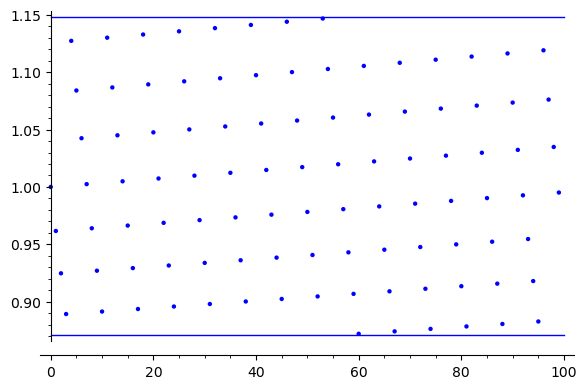

In [3]:
# Get asymptotic formula from previous calculation in "(pi, 1)-direction"
ASM = (ex*pw*se).subs(r=pi,s=1)

# Define oscillating factor
def M(n): return (pi/(pi+1))^(-round(n*pi)+n*pi)

# Plot oscillating factor, together with minimum and maximum
pt = plot(sqrt(pi/(pi+1)),n,0,100)
pt += plot(sqrt((pi+1)/pi),n,0,100)
for k in range(100):
    pt += point([k,M(k)])
pt

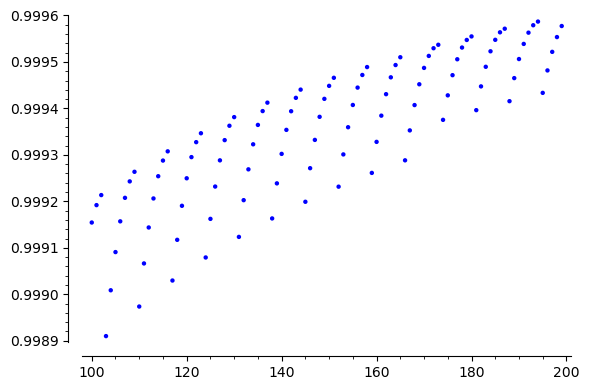

In [4]:
# Plot ratio of series coefficients and asymptotic behaviour
PTS = [binomial(round(pi*k)+k,k)/ASM.subs(n=k).n()/M(k) for k in range(100,201)]

pt = plot([])
for k in range(100):
    pt += point([k+100,PTS[k]])
    
pt

### Example 5.4 (Vanishing of Asymptotic Terms)

In [5]:
# Define parameters
var('x,y')
Ga = 1; Gb = x-2*y^2; Gc = x-y
H = 1-x-y
vars = [x,y]
R = [1,1]
M = 3

# Get critical point as function of r and s
CPs = critpt(H,R,vars)
CP = CPs[0]

# Parametrize y = g(x) = 1-x on V(H)
g = 1-x

# Print asymptotics
print("The main diagonal of F(x,y) = {} has expansion beginning".format(Ga/H))
ex,pw,se = smoothContrib(Ga,H,R,vars,CP,M,g)
disp_asm(ex,pw,se.expand(),M)

print("The main diagonal of F(x,y) = {} has expansion beginning".format(Gb/H))
ex,pw,se = smoothContrib(Gb,H,R,vars,CP,M,g)
disp_asm(ex,pw,se.expand(),M)

print("For the main diagonal of F(x,y) = {} we conclude only".format(Gc/H))
ex,pw,se = smoothContrib(Gc,H,R,vars,CP,M,g)
disp_asm(ex,pw,se,M)

The main diagonal of F(x,y) = -1/(x + y - 1) has expansion beginning


4^n/sqrt(n) \Bigg( 1/sqrt(pi) - 1/8/(sqrt(pi)*n) + 1/128/(sqrt(pi)*n^2) + O\Bigg( n^(-3) \Bigg)\Bigg)

The main diagonal of F(x,y) = (2*y^2 - x)/(x + y - 1) has expansion beginning


4^n/sqrt(n) \Bigg( 1/4/(sqrt(pi)*n) + 3/32/(sqrt(pi)*n^2) + O\Bigg( n^(-3) \Bigg)\Bigg)

For the main diagonal of F(x,y) = -(x - y)/(x + y - 1) we conclude only


4^n/sqrt(n) \Bigg( 0 + O\Bigg( n^(-3) \Bigg)\Bigg)

### Example 5.5 (Asymptotics of a Multinomial Expansion)

In [6]:
# Set basic info
var('x,y,z,a,b,c')
G = 1; H = 1-x-y-z
r = [a,b,c]
vars = [x,y,z]
CP = critpt(H,r,vars)[0]
M = 2
g = solve(H,vars[-1])[0].rhs()

# Determine asymptotics
ex,pw,se = smoothContrib(G,H,r,vars,CP,M,g)

# Simplify and print asymptotic expression
var('N')
se_simp = add([k.factor()/n^p for [k,p] in se.subs(n=1/N).series(N,2).coefficients()])
print("The {} diagonal of F(x,y) = {} has expansion beginning".format(r,G/H))
disp_asm(ex,pw,se_simp,M)

The [a, b, c] diagonal of F(x,y) = -1/(x + y + z - 1) has expansion beginning


((a + b + c)^(a + b + c)/(a^a*b^b*c^c))^n/(c*n) \Bigg( 1/2*sqrt(a + b + c)*sqrt(c)/(pi*sqrt(a)*sqrt(b)) - 1/24*(a + b)*(a + c)*(b + c)/(pi*sqrt(a + b + c)*a^(3/2)*b^(3/2)*sqrt(c)*n) + O\Bigg( n^(-2) \Bigg)\Bigg)

### Example 5.6 (Lattice Path Asymptotics)

In [7]:
# Set basic info
var('x,y,t')
G = (1+x)*(1+y); H = 1-t*x*y*(x+y+1/x+1/y)
r = [1,1,1]
vars = [x,y,t]
sigma = critpt(H,r,vars)[0]
tau = critpt(H,r,vars)[1]
M = 4
g = solve(H,vars[-1])[0].rhs()

# Determine asymptotics
ex1,pw1,se1 = smoothContrib(G,H,r,vars,sigma,M,g)
ex2,pw2,se2 = smoothContrib(G,H,r,vars,tau,M,g)

In [8]:
print("The asymptotic contribution of {} to diagonal asymptotics is".format(sigma))
disp_asm(ex1,pw1,se1.expand(),M)
print("The asymptotic contribution of {} to diagonal asymptotics is".format(tau))
disp_asm(ex2,pw2,se2.expand(),M)

The asymptotic contribution of {x: 1, y: 1, t: 1/4} to diagonal asymptotics is


4^n/n \Bigg( 4/pi - 6/(pi*n) + 19/2/(pi*n^2) - 63/4/(pi*n^3) + O\Bigg( n^(-4) \Bigg)\Bigg)

The asymptotic contribution of {x: -1, y: -1, t: -1/4} to diagonal asymptotics is


(-4)^n/n \Bigg( 1/(pi*n^2) - 9/2/(pi*n^3) + O\Bigg( n^(-4) \Bigg)\Bigg)

In [9]:
# Note that additional terms in the expansion can be computed very efficiently 
# from P-recurrence satisfied by the diagonal sequence / D-finite equation of the GF
from ore_algebra import *
Pols.<n> = PolynomialRing(QQ)
Shift.<Sn> = OreAlgebra(Pols)

# Import recurrence satisfied by diagonal sequence (obtained from kernel method and creative telescoping)
rec = (-n^2 - 7*n - 12)*Sn^2 + (8*n + 20)*Sn + 16*n^2 + 48*n + 32

# The asymptotic expansion of the diagonal will be a C-linear combination of these terms
# Looking at the dominant terms allows one to compute the coefficients (here 4/pi and 1/pi)
# This approach can compute about 20 terms in the expansion in one second on a modern laptop
show(rec.generalized_series_solutions(5))

[4^n*n^(-1)*(1 - 3/2*n^(-1) + 19/8*n^(-2) - 63/16*n^(-3) + 871/128*n^(-4) + O(n^(-5))),
 (-4)^n*n^(-3)*(1 - 9/2*n^(-1) + 107/8*n^(-2) - 525/16*n^(-3) + 9263/128*n^(-4) + O(n^(-5)))]

### Example 5.7 (Lonesum Matrices)

In [10]:
# Set basic info
var('x,y,a,b,r,s')
G = exp(x+y); H = exp(x)+exp(y)-exp(x+y)
R = [r,s]
vars = [x,y]
CP = dict([(x,a),(y,b)])
M = 1
g = x - log(exp(x)-1)

# Get asymptotics
ex,pw,se = smoothContrib(G,H,R,vars,CP,M,g)

In [11]:
# The leading constant is very complicated, as Sage doesn't know the relationship
# between (x,y) and (a,b).
print(se)

1/2*sqrt(2)*sqrt(pi)*sqrt(-((2*a - 1)*e^a + 1)*b*r*s*e^b + (b^2*(e^a - 1) + b*(e^a - 1))*r^2*e^b + (a^2*e^(a + b) - a^2*e^a)*s^2)*sqrt(b)*s*sqrt(e^a - 1)*e^(a + 1/2*b)/((pi*a - (2*pi*a^2 - pi*a)*e^(2*a) + 2*(pi*a^2 - pi*a)*e^a - (pi + (pi - 2*pi*a)*e^(2*a) - 2*(pi - pi*a)*e^a)*log(e^a - 1))*b*r*s*e^b + ((pi*a*e^(2*a) - 2*pi*a*e^a + pi*a - (pi + pi*e^(2*a) - 2*pi*e^a)*log(e^a - 1))*b^2 + (pi*a*e^(2*a) - 2*pi*a*e^a + pi*a - (pi + pi*e^(2*a) - 2*pi*e^a)*log(e^a - 1))*b)*r^2*e^b - (pi*a^3*e^(2*a) - pi*a^3*e^a - (pi*a^3*e^(2*a) - pi*a^3*e^a - (pi*a^2*e^(2*a) - pi*a^2*e^a)*log(e^a - 1))*e^b - (pi*a^2*e^(2*a) - pi*a^2*e^a)*log(e^a - 1))*s^2)


In [12]:
# It can be hard to get Sage to fully simplify in the general case,
# but easy to simplify for explicit points. Here is one example.
sbs = [r==1,s==1,a==log(2),b==log(2)]
disp_asm(ex.subs(sbs), pw.subs(sbs), se.subs(sbs).canonicalize_radical(),M)

log(2)^(-2*n)/sqrt(n) \Bigg( -I*sqrt(pi)*sqrt(log(2) - 1)/(pi*log(2)^2 - pi*log(2)) + O\Bigg( 1/n \Bigg)\Bigg)

In [13]:
# The leading constant has been published in the literature as
C = 1/sqrt(pi*(1-log(2)))/log(2)
show("C = ",C)

'C = ' 1/(sqrt(-pi*(log(2) - 1))*log(2))

In [14]:
# This is the same as our computed constant
(C/se.subs(sbs)).canonicalize_radical()

1

### Example 5.9 (Asymptotics of Apéry Numbers)

In [15]:
# Apéry sequence for ζ(3)
var('x,y,z,t')
G = 1; H = 1 - t*(1+x)*(1+y)*(1+z)*(1+y+z+y*z+x*y*z)
r = [1,1,1,1]
vars = [x,y,z,t]
CPs = critpt(H,r,vars)
CP = CPs[1]
M = 1
g = solve(H,vars[-1])[0].rhs()
field = QQbar

# Determine asymptotics
ex,pw,se = smoothContrib(G,H,r,vars,CP,M,g)

# Print results
print("The Apéry numbers for ζ(3) have asymptotic expansion")
disp_asm(ex,pw,se.expand(),M)

The Apéry numbers for ζ(3) have asymptotic expansion


(12*sqrt(2) + 17)^n/n^(3/2) \Bigg( 1/8*sqrt(2)*sqrt(17*sqrt(2) + 24)/pi^(3/2) + O\Bigg( 1/n \Bigg)\Bigg)

In [16]:
# Apéry sequence for ζ(2)
var('x,y,z')
G = 1; H = 1 -z*(1+x)*(1+y)*(1+y+x*y)
r = [1,1,1]
vars = [x,y,z]
CPs = critpt(H,r,vars)
CP = CPs[0]
M = 1
g = solve(H,vars[-1])[0].rhs()

# Determine asymptotics
ex,pw,se = smoothContrib(G,H,r,vars,CP,M,g)

# Print results
print("The Apéry numbers for ζ(2) have asymptotic expansion")
disp_asm(ex,pw,se,M)

The Apéry numbers for ζ(2) have asymptotic expansion


(5/2*sqrt(5) + 11/2)^n/n \Bigg( -1/2*sqrt(2)*sqrt(-11*sqrt(5) + 25)/(pi*(11*sqrt(5) - 25)) + O\Bigg( 1/n \Bigg)\Bigg)

In [17]:
# In the textbook example we use the following value of the constant
C = (sqrt(250+110*sqrt(5))/20/pi)
C

1/20*sqrt(110*sqrt(5) + 250)/pi

In [18]:
# This is equivalent to what we calculate here
(se/C).minpoly().roots(multiplicities=False)

[1]

### Example 5.10 (Asymptotics of Bar Graphs)

In [19]:
# Recompute the rational function encoding the generating function from Example 3.12
var('x,y,z,a')
P = z - x*y - (x+y+x*y)*z - x*z^2
R = (z^2*(diff(P,z)/P).subs(y=y*z)).factor()
show(LatexExpr("[x^iy^j]B(x,y) = [x^iy^jz^j]"),R)

[x^iy^j]B(x,y) = [x^iy^jz^j] (x*y*z + 2*x*z + y*z + x - 1)*z/(x*y*z + x*y + x*z + y*z + x - 1)

In [20]:
# There are two critical points, one of which is has positive coordinates
G = R.numerator(); H = R.denominator()
r = [a,1,1]
vars = [x,y,z]
CPs = critpt(H,r,vars)
show(CPs)

[{x: (sqrt(a^2 + 4) - 2)/a,
  y: -1/2*a + 1/2*sqrt(a^2 + 4),
  z: -1/2*a + 1/2*sqrt(a^2 + 4)},
 {x: -(sqrt(a^2 + 4) + 2)/a,
  y: -1/2*a - 1/2*sqrt(a^2 + 4),
  z: -1/2*a - 1/2*sqrt(a^2 + 4)}]

In [21]:
# Select the critical point with positive coordinates
[CP] = [k for k in CPs if x(k).subs(a=1)>0]
CP

{x: (sqrt(a^2 + 4) - 2)/a,
 y: -1/2*a + 1/2*sqrt(a^2 + 4),
 z: -1/2*a + 1/2*sqrt(a^2 + 4)}

In [22]:
# This point is minimal as long as the following polynomial in t has no root in (0,1)
var('t')
p = H.subs([v == v*t for v in vars]).subs(CP).factor()
show(p)

-1/2*(a^3*t^2 - sqrt(a^2 + 4)*a^2*t^2 + 2*a^2*t^2 - 2*sqrt(a^2 + 4)*a*t^2 + 4*a*t^2 - 2*sqrt(a^2 + 4)*t^2 - 2*a*t + 4*t^2 + 2*sqrt(a^2 + 4)*t - 2*a - 4*t)*(t - 1)/a

In [23]:
# Thus we need to prove the following quadratic has, for any a>0, no root of t in (0,1)
q = p/(t-1)*2*a
q

-a^3*t^2 + sqrt(a^2 + 4)*a^2*t^2 - 2*a^2*t^2 + 2*sqrt(a^2 + 4)*a*t^2 - 4*a*t^2 + 2*sqrt(a^2 + 4)*t^2 + 2*a*t - 4*t^2 - 2*sqrt(a^2 + 4)*t + 2*a + 4*t

In [24]:
# The vertex of the parabola in t defined by q(t)=0 has negative coordinates when a>0
vertex = q.diff(t).solve(t)[0].rhs()
print("The value of q(t) at the vertex t = {} is {}".format(vertex,q.subs(t=vertex).simplify_full()))

The value of q(t) at the vertex t = -1/2*(a^2 + sqrt(a^2 + 4)*(a + 1) + a + 2)/a is a - sqrt(a^2 + 4)


In [25]:
# Thus, since q(0)>0 the factor q(t) has no root with t>0 when a>0
q.subs(t=0)

2*a

In [26]:
# Determine asymptotics (this takes a *long* time) -- uncomment last line to run
# First order term vanishes so second order term needed
M = 2
g = solve(H,vars[-1])[0].rhs()
# ex,pw,se = smoothContrib(G,H,r,vars,CP,M,g)

### Example 5.11 (Non-Finitely Minimal Critical Point)

In [27]:
var('x,y')
G = 1; H = (1+2*x)*(1-x-y)
r = [1,1]
vars = [x,y]
CPs = critpt(H,r,vars)
CP = CPs[0]
M = 5
g = solve(H,vars[-1])[0].rhs()

# Determine asymptotics
ex,pw,se = smoothContrib(G,H,r,vars,CP,M,g)

# Print result
disp_asm(ex,pw,se.expand(),M)

4^n/sqrt(n) \Bigg( 1/2/sqrt(pi) - 1/8/(sqrt(pi)*n) + 1/256/(sqrt(pi)*n^2) + 5/256/(sqrt(pi)*n^3) + 819/65536/(sqrt(pi)*n^4) + O\Bigg( n^(-5) \Bigg)\Bigg)

### Example 5.12 (Local Central Limit Theorem for Weighted Walks)

In [28]:
# Define the function F = G/H and find the minimal critical point
var('x,y')
G = 1; H = 1-y*(x+1+2/x)
m = [-1/4,1]
vars = [x,y]
CPs = critpt(H,m,vars)
[CP] = [k for k in CPs if x(k)>0]
CP

{x: 1, y: 1/4}

In [29]:
# The largest coefficient of [y^n]F(x,y) as a function of x has the following asymptotic behaviour
g = solve(H,vars[-1])[0].rhs()
ex,pw,se = smoothContrib(G,H,m,vars,CP,1,g)
asm = ex*pw*se
show(asm)

2/11*sqrt(11)*sqrt(2)*4^n/(sqrt(pi)*sqrt(n))

In [30]:
# After scaling by asm, the coefficients of [y^n]F(x,y) approach the following normal distribution
var('n,ep')
hes = getHes(H,m,vars,CP)[0,0]
norm = exp(-n*(ep-m[0])^2/2/hes)
norm

e^(-1/22*(4*ep + 1)^2*n)

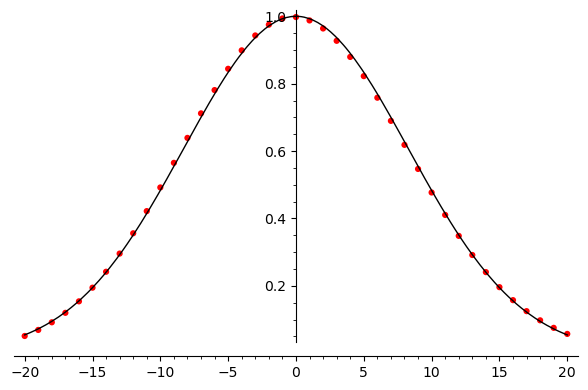

In [31]:
# Plot the series coefficients of [y^N]F(x,y)/asm(n=N) compared to the limit curve
N = 100
SN = ((x+1+2/x)^N).expand()
mm = m[0]*N

pt = plot([])
for k in range(-20,21):
    pt += point([k,SN.coefficient(x,mm+k)/asm.subs(n=N)], size=20, color='red')

var('L')
pt += plot(norm.subs(ep=m[0]+L/N,n=N),L,-20,20, color='black')
pt